# The Relationship Between a Hotel's Geographical Proximity to the Center of the Country and Its Price

* Yarin Cohen, ID: 211361720
* Amit Shiber, ID: 322372582

## About Our Project

From time to time the issue of the periphery versus the center of the country comes up in the media. We decided to research more about the subject and check the hotel prices in the cities near Tel Aviv and in the distant cities. After crawling the data from the hotel website, we will use an additional function with an API to calculate distances between two locations. Is there a connection between the price of hotel charges and its proximity to the center of country?

### Information Sources and Data Acquisition Methods

* **Crawling Booking.com** - One of the largest online travel agencies. As of December 31, 2022, Booking.com offered lodging reservation services for approximately 2.7 million properties, including 400,000 hotels, motels, and resorts and 2.3 million homes, apartments in over 220 countries and in over 40 languages. It will help us getting data about the hotels in this project.

* **GeoDB Cities API** - Online cities database. It exposes city, region, and country data via both GraphQL and REST APIs. It will help us calculate the distance between two cities.

### Data Set Description

Each line in the data set represents a hotel.

Columns representation in the data set:
* Hotel name
* Hotel Address
* Hotel Description
* Price per night (on a fixed date, the cheapest deal)
* Score - general
* Score - stuff
* Score - facilities
* Score - convenience
* Score - value for money
* Score - location
* Score - clean
* Proximity to the center of the country (km)

### Machine Learning

* **Type of ML**: Regression

* We will start with easy regression models (one variable and low powers) and try to go through each pair of an explanatory variable and an explained variable.

* There is no rule that says how many variables make a regression heavy and sluggish. If the software starts to falter, we will stop and think whether adding the variables and holdings will contribute to the prediction or only to the complications of calculation, memory, etc. We are required to exercise discretion between predictability and complications and resources such as private time.

* If the learning results are not satisfactory, we will use
in classification and division into price levels.

## Imports

In [51]:
import requests
import bs4
from bs4 import BeautifulSoup
import time
import random
from tqdm import tqdm
import pandas as pd
import scipy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import sklearn
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, f1_score
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

## Step 1: Defining a Research Question

Is it possible to predict the price of a night in a certain hotel, based on its proximity to the center and the score given to it by surfers in the various categories?

## Step 2: Data Acquisition

### Data Acquisition by Crawling

First of all, we will check Booking.com's Robots.txt terms, to understand if there are any pages we can't crawl: https://booking.com/robots.txt

* We will start by searching manually on Booking's main page for a vacation in Israel, on 03-04/09/2023.

* The results page will be crawled first.
* Due to complexity of HTML elements, we will use the mobile version of Booking.
* <a href="https://www.booking.com/searchresults.he.html?ss=%D7%99%D7%A9%D7%A8%D7%90%D7%9C&ss=%D7%99%D7%A9%D7%A8%D7%90%D7%9C&group_adults=2&group_children=0&no_rooms=1&sb_travel_purpose=leisure&ssne=%D7%99%D7%A9%D7%A8%D7%90%D7%9C&ssne_untouched=%D7%99%D7%A9%D7%A8%D7%90%D7%9C&sb_changed_dates=1&label=gen173nr-1BCAEoggI46AdIM1gEaGqIAQGYAQ64AQfIAQzYAQHoAQGIAgGoAgO4AsPO_6IGwAIB0gIkN2EzYmVmMjgtNTkwYS00YjMyLWI5ZmUtMmZjMTQwOTdmM2I42AIF4AIB&sid=ae3ca57b743d1747c5f828a2fabc4587&aid=304142&lang=he&sb=1&src_elem=sb&src=searchresults&dest_id=103&dest_type=country&checkin=2024-02-01&checkout=2024-02-02&prefer_site_type=mdot" >This is</a> the first page will be crawled.

#### Auxiliary Functions

In [2]:
# Load soup object:

def loadSoupObject(url):

    headers = { "User-Agent": "Mozilla/5.0 (iPhone; CPU iPhone OS 15_0 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/15E148" }
    
    time.sleep(random.randint(1,5))
    r = requests.get(url, headers=headers).content
    
    return BeautifulSoup(r,"html.parser")

In [3]:
# Getting URLs of all the hotels in the page:

def getHotelsURL(soupObj):

    links = []
   
    for link in soupObj.findAll("a", {"data-testid" : "title"}):
        links.append(link.get("href"))

    return links

In [4]:
# Getting URL of the next results page:

def getNextPage(soupObj):
    return soupObj.find("a", {"title" : "Next page"}).get("href")

In [5]:
# Getting information from a hotel page:

def getHotelData(soupObj):

    dataOfHotel = []

    # Hotel name:
    name = soupObj.find("span",{"class" : "hp-header--title--text"})
    dataOfHotel.append(name.text if name else np.nan)

    # Hotel address:
    add = soupObj.find("span",{"class" : "js_hp_address_text_line"})
    dataOfHotel.append(add.text if add else np.nan)

    # Hotel description:
    desc = soupObj.find("div",{"class" : "page-section--content"})
    dataOfHotel.append(desc.text if desc else np.nan)
    
    # Price per night (on a fixed date, the cheapest deal):
    price = soupObj.find("div",{"class" : "prco-js-headline-price"})
    dataOfHotel.append(price.text if price else np.nan)

    # Score - general:
    score = soupObj.find("div",{"data-testid" : "review-score-component"})
    dataOfHotel.append(score.text if score else np.nan)

    # Score - value for money:
    value = soupObj.find("div",{"id" : ":R5m:-label"})
    dataOfHotel.append(value.text if value else np.nan)

    # Score - location:
    location = soupObj.find("div",{"id" : ":R4m:-label"})
    dataOfHotel.append(location.text if location else np.nan)

    # Score - clean:
    clean = soupObj.find("div",{"id" : ":R56:-label"})
    dataOfHotel.append(clean.text if clean else np.nan)

    return dataOfHotel


In [6]:
# The whole process of crawling all the hotels from results pages:

def getAllHotels(urlResults):

    currentPage = loadSoupObject(urlResults)

    resultsPages = []
    hotelsLinks = []

    # Collecting links of results pages:

    resultsPages.append(currentPage)

    for i in tqdm(range(33), desc="Collecting next-links..."):
        
        if (currentPage.find("a", {"title" : "Next page"})):
            nextPage = loadSoupObject(getNextPage(currentPage))
            resultsPages.append(nextPage)
            currentPage = nextPage

            if not (currentPage.find("a", {"title" : "Next page"})):
                break

    # Collecting links of hotels:

    for page in tqdm(resultsPages,desc="Collecting links from result pages..."):
        hotelsLinks.extend(getHotelsURL(page))

    # Crawling data from hotel pages

    hotelsData = []

    for link in tqdm(hotelsLinks, desc="Crawling hotels data..."):
        hotelsData.append(getHotelData(loadSoupObject(link)))

    return hotelsData

#### Main Function

First, we start by crawling the results pages when searching for "Israel", "Herzliya", etc. in the search bar found on the home page.
- Crawling all "next page" links found on the results pages.

- Crawling all the links of the hotel pages found in the results pages.
- Crawling the data from each hotel page.

Here we can see an array of 18 links, which were obtained as a result of searching these phrases on the homepage of Booking.com.

These links are not displayed in one place on Booking.com. Therefore, we had to copy and paste them, instead of crawling them as well.

In [7]:
searches = [
    # All of Israel:
    "https://www.booking.com/searchresults.en-us.html?ss=israel&ssne=Upper+Galilee&ssne_untouched=Upper+Galilee&label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&lang=en-us&sb=1&src_elem=sb&src=searchresults&dest_id=103&dest_type=country&ac_position=0&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=57b8636d07030080&ac_meta=GhA1N2I4NjM2ZDA3MDMwMDgwIAAoATICZW46BWlzcmFlQABKAFAA&checkin=2023-09-03&checkout=2023-09-04&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure",
    # Herzelia:
    "https://www.booking.com/searchresults.en-us.html?ss=Herzelia+%2C+Center+District+Israel%2C+Israel&ssne=Israel&ssne_untouched=Israel&label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&lang=en-us&sb=1&src_elem=sb&src=searchresults&dest_id=-780136&dest_type=city&ac_position=0&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=347f65e8986607e2&ac_meta=GhAzNDdmNjVlODk4NjYwN2UyIAAoATICZW46B2hlcnplbGlAAEoAUAA%3D&checkin=2023-09-03&checkout=2023-09-04&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure",
    # Netanya:
    "https://www.booking.com/searchresults.en-us.html?ss=Netanya&ssne=Herzliya&ssne_untouched=Herzliya&label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&lang=en-us&sb=1&src_elem=sb&src=searchresults&checkin=2023-09-03&checkout=2023-09-04&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure",
    # Mizpe Ramon:
    "https://www.booking.com/searchresults.en-us.html?ss=Mizpe+Ramon&ssne=Netanya&ssne_untouched=Netanya&label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&lang=en-us&sb=1&src_elem=sb&src=searchresults&dest_id=900040703&dest_type=city&ac_position=0&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=54a2660fa2bc0084&ac_meta=GhA1NGEyNjYwZmEyYmMwMDg0IAAoATICZW46C01penBlIFJhbW9uQAFKDG1pdHpwZSByYW1vblCGAQ%3D%3D&checkin=2023-09-03&checkout=2023-09-04&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure",
    # Yeruham:
    "https://www.booking.com/searchresults.en-us.html?ss=Yeruham&ssne=Mitzpe+Ramon&ssne_untouched=Mitzpe+Ramon&label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&lang=en-us&sb=1&src_elem=sb&src=searchresults&checkin=2023-09-03&checkout=2023-09-04&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure",
    # Haifa:
    "https://www.booking.com/searchresults.en-us.html?ss=Haifa&ssne=Yero%E1%BA%96am&ssne_untouched=Yero%E1%BA%96am&label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&lang=en-us&sb=1&src_elem=sb&src=searchresults&checkin=2023-09-03&checkout=2023-09-04&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure",
    # Nazareth:
    "https://www.booking.com/searchresults.en-us.html?ss=Nazareth%2C+North+District+Israel%2C+Israel&ssne=Haifa&ssne_untouched=Haifa&label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&lang=en-us&sb=1&src_elem=sb&src=searchresults&dest_id=-780833&dest_type=city&ac_position=0&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=b924663990bd0516&ac_meta=GhBiOTI0NjYzOTkwYmQwNTE2IAAoATICZW46CE5hemFyZXRoQABKAFAA&checkin=2023-09-03&checkout=2023-09-04&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure",
    # Israel's north district:
    "https://www.booking.com/searchresults.en-us.html?ss=North+District+Israel%2C+Israel&ssne=Nazareth&ssne_untouched=Nazareth&label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&lang=en-us&sb=1&src_elem=sb&src=searchresults&dest_id=3638&dest_type=region&ac_position=1&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=25686645b89502a2&ac_meta=GhAyNTY4NjY0NWI4OTUwMmEyIAEoATICZW46B2lzcmFlbCBAAEoAUAA%3D&checkin=2023-09-03&checkout=2023-09-04&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure",
    # Israel's center district:
    "https://www.booking.com/searchresults.en-us.html?ss=Center+District+Israel%2C+Israel&ssne=North+District+Israel&ssne_untouched=North+District+Israel&label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&lang=en-us&sb=1&src_elem=sb&src=searchresults&dest_id=3640&dest_type=region&ac_position=3&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=45f86657a1f70228&ac_meta=GhA0NWY4NjY1N2ExZjcwMjI4IAMoATICZW46BmlzcmFlbEAASgBQAA%3D%3D&checkin=2023-09-03&checkout=2023-09-04&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure",
    # Israel's south district:
    "https://www.booking.com/searchresults.en-us.html?ss=South+District+Israel%2C+Israel&ssne=Center+District+Israel&ssne_untouched=Center+District+Israel&label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&lang=en-us&sb=1&src_elem=sb&src=searchresults&dest_id=3642&dest_type=region&ac_position=0&ac_click_type=b&ac_langcode=en&ac_suggestion_list_length=5&search_selected=true&search_pageview_id=fc976674c81401ea&ac_meta=GhBmYzk3NjY3NGM4MTQwMWVhIAAoATICZW46FXNvdXRoIERpc3RyaWN0IElzcmFlbEAASgBQAA%3D%3D&checkin=2023-09-03&checkout=2023-09-04&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure",
    # Tel Aviv:
    "https://www.booking.com/searchresults.en-us.html?ss=Tel+Aviv&ssne=Tel+Aviv&ssne_untouched=Tel+Aviv&efdco=1&label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&lang=en-us&sb=1&src_elem=sb&src=searchresults&dest_id=-781545&dest_type=city&checkin=2023-09-03&checkout=2023-09-04&ltfd=1%3A1%3A9-2023%3A&group_adults=2&no_rooms=1&group_children=0&sb_travel_purpose=leisure",
    # Jerusalem:
    "https://www.booking.com/searchresults.html?label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&checkin=2023-09-03&checkout=2023-09-04&dest_id=900000000&dest_type=city&group_adults=null&req_adults=null&no_rooms=null&group_children=null&req_children=null",
    # Dead Sea:
    "https://www.booking.com/searchresults.html?label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&checkin=2023-09-03&checkout=2023-09-04&dest_id=3230&dest_type=region&group_adults=null&req_adults=null&no_rooms=null&group_children=null&req_children=null",
    # Tiberias:
    "https://www.booking.com/searchresults.html?label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&checkin=2023-09-03&checkout=2023-09-04&dest_id=-781620&dest_type=city&group_adults=null&req_adults=null&no_rooms=null&group_children=null&req_children=null",
    # Golan Heights:
    "https://www.booking.com/searchresults.html?label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&checkin=2023-09-03&checkout=2023-09-04&dest_id=3644&dest_type=region&group_adults=null&req_adults=null&no_rooms=null&group_children=null&req_children=null",
    # Safed:
    "https://www.booking.com/searchresults.html?label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&checkin=2023-09-03&checkout=2023-09-04&dest_id=-781845&dest_type=city&group_adults=null&req_adults=null&no_rooms=null&group_children=null&req_children=null",
    # Zikhron Yaakov:
    "https://www.booking.com/searchresults.html?label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&checkin=2023-09-03&checkout=2023-09-04&dest_id=-781878&dest_type=city&group_adults=null&req_adults=null&no_rooms=null&group_children=null&req_children=null",
    # Upper Galile:
    "https://www.booking.com/searchresults.html?label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AtDFqKMGwAIB0gIkMjI2NjFiN2ItODhhYS00ZmYwLWIyMDUtMzdlOTc5OWU5OGZi2AIF4AIB&sid=863fbc6e6306cb97b7ec9fa1361b67a2&aid=304142&checkin=2023-09-03&checkout=2023-09-04&dest_id=7336&dest_type=region&group_adults=null&req_adults=null&no_rooms=null&group_children=null&req_children=null"
]

fullData = []

In [8]:
for index, url in enumerate(searches):
    print("Cycle",index+1)
    fullData.extend(getAllHotels(url))
    print("")

Cycle 1


Crawling hotels data...: 100%|██████████| 1020/1020 [1:44:12<00:00,  6.13s/it]



Cycle 2


Crawling hotels data...: 100%|██████████| 591/591 [58:02<00:00,  5.89s/it]  



Cycle 3


Crawling hotels data...: 100%|██████████| 78/78 [06:45<00:00,  5.20s/it]



Cycle 4


Crawling hotels data...: 100%|██████████| 24/24 [02:22<00:00,  5.92s/it]



Cycle 5


Crawling hotels data...: 100%|██████████| 43/43 [03:48<00:00,  5.32s/it]



Cycle 6


Crawling hotels data...: 100%|██████████| 180/180 [17:22<00:00,  5.79s/it]



Cycle 7


Crawling hotels data...: 100%|██████████| 41/41 [03:49<00:00,  5.59s/it]



Cycle 8


Crawling hotels data...: 100%|██████████| 1020/1020 [1:35:54<00:00,  5.64s/it]



Cycle 9


Crawling hotels data...: 100%|██████████| 654/654 [1:04:12<00:00,  5.89s/it]



Cycle 10


Crawling hotels data...: 100%|██████████| 477/477 [45:19<00:00,  5.70s/it]



Cycle 11


Crawling hotels data...: 100%|██████████| 381/381 [38:52<00:00,  6.12s/it]



Cycle 12


Crawling hotels data...: 100%|██████████| 297/297 [27:51<00:00,  5.63s/it]



Cycle 13


Crawling hotels data...: 100%|██████████| 88/88 [08:13<00:00,  5.61s/it]



Cycle 14


Crawling hotels data...: 100%|██████████| 107/107 [09:56<00:00,  5.57s/it]



Cycle 15


Crawling hotels data...: 100%|██████████| 281/281 [24:26<00:00,  5.22s/it]



Cycle 16


Crawling hotels data...: 100%|██████████| 66/66 [06:01<00:00,  5.48s/it]



Cycle 17


Crawling hotels data...: 100%|██████████| 147/147 [13:03<00:00,  5.33s/it]



Cycle 18


Crawling hotels data...: 100%|██████████| 586/586 [51:59<00:00,  5.32s/it] 

In [9]:
# Creating a data set:

headers = ["hotelName", "hotelAddress", "hotelDescription", "pricePerNight","scoreGeneral","scoreValueForMoney","scoreLocation","scoreClean"]

df = pd.DataFrame(fullData, columns=headers)
df

,hotelName,hotelAddress,hotelDescription,pricePerNight,scoreGeneral,scoreValueForMoney,scoreLocation,scoreClean
0,Melio Hotel Eilat,"\nSderot Hativat HaNegev 20, Eilat\n","\nSet in Eilat, within 1.2 km of Kisuski Beach...",\n₪ 286\n,"7.9 Good · 1,075 reviews",8.4,7.8,8.4
1,Badolina Ein Gedi Glamping,"\nEin Gedi Street, Ein Gedi\n","\nDead Sea Camping is set in Ein Gedi, within ...",\n₪ 130\n,8.5 Very good · 814 reviews,7.7,9.2,8.3
2,Daniel Herzliya Hotel,"\n60 Ramat Yam Street, Herzelia \n","\nSet right on the beach, in the heart of Herz...",\n₪ 777\n,7.9 Good · 162 reviews,7.5,9.0,8.0
3,Merom Golan Resort,"\nKibbutz Merom Golan, Merom Golan\n",\nMerom Golan Resort offers quiet mountain acc...,\n₪ 983\n,"8.7 Fabulous · 1,400 reviews",7.9,9.4,8.9
4,Leonardo Club Hotel Dead Sea - All Inclusive,"\nEin Bokek (Dead sea), Ein Bokek\n",\nThis all-inclusive deluxe hotel is set a pri...,"\n₪ 1,308\n","7.7 Good · 6,414 reviews",7.4,8.7,7.5
...,...,...,...,...,...,...,...,...
6076,צימר נוף העמק,"\n28 נוף העמק, Nof Kinneret\n","\nSituated in Nof Kinneret, 4.7 km from Israel...","\n₪ 1,454\n",8.0 Very good · 1 review,10,10,10
6077,Supreme 4BR Villa With Garden and Sea View,"\n55 Jabotinski Street, Nahariyya\n",\nSituated in Nahariyya and only 400 m from Ha...,"\n₪ 4,087\n",NaN,NaN,NaN,NaN
6078,Blue lake luxury villa for families,"\nעין אל אסד, ‘Ein el Asad\n",\nLocated in ‘Ein el Asad and only 37 km from ...,"\n₪ 4,160\n",6.0 Pleasant · 1 review,NaN,NaN,NaN
6079,Paradise by the sea,"\nדוגית, Nahariyya\n","\nParadise by the sea is located in Nahariyya,...","\n₪ 2,880\n",NaN,NaN,NaN,NaN


In [ ]:
# Export data set to csv:
df.to_csv("Data/data.csv", index=False)

In [3]:
# Load data set from csv (for personal use):
df = pd.read_csv("Data/data.csv")

In [4]:
df

,hotelName,hotelAddress,hotelDescription,pricePerNight,scoreGeneral,scoreValueForMoney,scoreLocation,scoreClean
0,Melio Hotel Eilat,"\nSderot Hativat HaNegev 20, Eilat\n","\nSet in Eilat, within 1.2 km of Kisuski Beach...",\n₪ 286\n,"7.9 Good · 1,075 reviews",8.4,7.8,8.4
1,Badolina Ein Gedi Glamping,"\nEin Gedi Street, Ein Gedi\n","\nDead Sea Camping is set in Ein Gedi, within ...",\n₪ 130\n,8.5 Very good · 814 reviews,7.7,9.2,8.3
2,Daniel Herzliya Hotel,"\n60 Ramat Yam Street, Herzelia \n","\nSet right on the beach, in the heart of Herz...",\n₪ 777\n,7.9 Good · 162 reviews,7.5,9.0,8.0
3,Merom Golan Resort,"\nKibbutz Merom Golan, Merom Golan\n",\nMerom Golan Resort offers quiet mountain acc...,\n₪ 983\n,"8.7 Fabulous · 1,400 reviews",7.9,9.4,8.9
4,Leonardo Club Hotel Dead Sea - All Inclusive,"\nEin Bokek (Dead sea), Ein Bokek\n",\nThis all-inclusive deluxe hotel is set a pri...,"\n₪ 1,308\n","7.7 Good · 6,414 reviews",7.4,8.7,7.5
...,...,...,...,...,...,...,...,...
6076,צימר נוף העמק,"\n28 נוף העמק, Nof Kinneret\n","\nSituated in Nof Kinneret, 4.7 km from Israel...","\n₪ 1,454\n",8.0 Very good · 1 review,10.0,10.0,10.0
6077,Supreme 4BR Villa With Garden and Sea View,"\n55 Jabotinski Street, Nahariyya\n",\nSituated in Nahariyya and only 400 m from Ha...,"\n₪ 4,087\n",NaN,NaN,NaN,NaN
6078,Blue lake luxury villa for families,"\nעין אל אסד, ‘Ein el Asad\n",\nLocated in ‘Ein el Asad and only 37 km from ...,"\n₪ 4,160\n",6.0 Pleasant · 1 review,NaN,NaN,NaN
6079,Paradise by the sea,"\nדוגית, Nahariyya\n","\nParadise by the sea is located in Nahariyya,...","\n₪ 2,880\n",NaN,NaN,NaN,NaN


In [5]:
df.shape

(6081, 8)

Currently the data size is 6081 * 8 = 48,648.

We're not done getting all the data yet, and we'll have a few more columns, like distanceToTlv and address details. These columns will be added during and after the Data Handling step.

Finally the data size will be XXXX.

## Step 3: Data Handling

At this point, we will need to handle our data and organize it. For example, in the hotel data we crawled, some hotels do not have ratings on Booking.com. In addition, we will have to deal with duplicate hotels and outliers that do not reflect most of our data. Let's go for it!

### Auxiliary Functions

#### Cleaning Data

In [6]:
#extract the adress to three new columns
#as function
def addTwoCol(df):

    newDf = df.copy()

    #create 3 new columns
    #newDf['House Number'] = ''
    newDf['Street'] = ''
    newDf['City'] = ''

    #extract the data
    #newDf['House Number'] = newDf['hotelAddress'].str.split(' ').str[0]
    newDf['Street'] = newDf['hotelAddress'].str.split(',').str[0]
    #newDf['street'] = newDf['hotelAddress'].str.extract(r'\s(.*?)\,')
    #newDf['Street'] = newDf['hotelAddress'].str.extract(r'^(.*?),')
    newDf['City'] = newDf['hotelAddress'].str.split(',', 1).str[1].str.strip()

    return newDf 


In [7]:
# # add a column with the distance from TLV
#  #for check
# df1['distance-TLV'] = ''

# city_name = df1['City'].tolist()
# print(city_name)
# TLVDis= []
# for city in city_name:
#     time.sleep(2)
#     city_id = getCityID(city)
#     time.sleep(1)
#     city_distance = getCityDistance(city_id)
#     TLVDis.append(city_distance)


# for j in range(len(TLVDis)):
#     df1.at[j,'distance-TLV'] = TLVDis[j]


# print(df1)

In [8]:
# Handling "/n" signs and others

def cleanSigns(df, cols):

    newDf = df.copy()

    for column in cols:
        newDf[column] = newDf[column].str.replace("[\n\t\r₪]", "", regex=True)

    return newDf

In [9]:
# Extracting "generalScore" from a columm:

def extractNumbers(df, column):

    newDf = df.copy()
    newDf[column] = newDf[column].str.split().str[0]

    return newDf

In [10]:
# Converting text columns to numbers:

def convertToNum(df, cols):
    
    newDf = df.copy()

    for column in cols:
        newDf[column] = pd.to_numeric(df[column], errors="coerce")
    
    return newDf

In [11]:
# Removing space and comma from a column:

def removeSpaceComma(df, column):
    
    newDf = df.copy()
    newDf[column] = newDf[column].str.replace("[\s,]", "", regex=True)
    
    return newDf

#### Handling duplicates

In [12]:
# Count duplications:

def countDup(df):
    sum = df.duplicated().sum()
    return df[df.duplicated()].shape

# AMIT I THINK THERE IS A MISTAKE HERE

In [13]:
# Delete the duplicated rows:

def deleteDup(df):
    newDf = df.copy()
    return newDf.drop_duplicates()

#### Handling missing data


In [14]:
# Clean all the rows with more than x NaN:

def cleanTreshRows(df, numMmaxMissingCols):
    newdf = df.copy()
    return newdf.dropna(thresh = df.shape[1] - numMmaxMissingCols).copy()

In [15]:
# Replace missing strings with "bla" and missing nums with the median:

def replaceMissingValues(df):

    newDf = df.copy()

    for col in newDf.columns: 
        if newDf[col].dtype in ['float64', 'int64']:
            newDf[col].fillna(newDf[col].median(), inplace=True)

        elif newDf[col].dtype == 'object':
            newDf[col].fillna('bla', inplace=True)
            
    return newDf

#### Handling outliers:

In [49]:
# Presenting boxplot of IQR and returns number of outliers:

def showOutliers(df, column):

    sns.boxplot(df[column])

    Q1 = np.percentile(df[column], 25)
    Q3 = np.percentile(df[column], 75)
    IQR = Q3 - Q1

    return len(df[(df[column] < Q1 - 1.5*IQR) | (df[column] > Q3 + 1.5*IQR)])

In [ ]:
# Replace outliers:

def (df):

    newDf = df.copy()

    Q1 = 
    Q2 = 
    IQR = 

    d

### Main Function

In [41]:
df = pd.read_csv("Data/data.csv")

In [42]:
# Main:

# Cleaning the data:
df = cleanSigns(df,["hotelAddress","hotelDescription","pricePerNight"])
df = removeSpaceComma(df, "pricePerNight")
df = extractNumbers(df,"scoreGeneral")
df = convertToNum(df, ["pricePerNight","scoreGeneral","scoreValueForMoney","scoreLocation","scoreClean"])
df = cleanTreshRows(df,5)
df = addTwoCol(df)

In [43]:
df

,hotelName,hotelAddress,hotelDescription,pricePerNight,scoreGeneral,scoreValueForMoney,scoreLocation,scoreClean,Street,City
0,Melio Hotel Eilat,"Sderot Hativat HaNegev 20, Eilat","Set in Eilat, within 1.2 km of Kisuski Beach a...",286.0,7.9,8.4,7.8,8.4,Sderot Hativat HaNegev 20,Eilat
1,Badolina Ein Gedi Glamping,"Ein Gedi Street, Ein Gedi","Dead Sea Camping is set in Ein Gedi, within 1 ...",130.0,8.5,7.7,9.2,8.3,Ein Gedi Street,Ein Gedi
2,Daniel Herzliya Hotel,"60 Ramat Yam Street, Herzelia","Set right on the beach, in the heart of Herzli...",777.0,7.9,7.5,9.0,8.0,60 Ramat Yam Street,Herzelia
3,Merom Golan Resort,"Kibbutz Merom Golan, Merom Golan",Merom Golan Resort offers quiet mountain accom...,983.0,8.7,7.9,9.4,8.9,Kibbutz Merom Golan,Merom Golan
4,Leonardo Club Hotel Dead Sea - All Inclusive,"Ein Bokek (Dead sea), Ein Bokek",This all-inclusive deluxe hotel is set a priva...,1308.0,7.7,7.4,8.7,7.5,Ein Bokek (Dead sea),Ein Bokek
...,...,...,...,...,...,...,...,...,...,...
6076,צימר נוף העמק,"28 נוף העמק, Nof Kinneret","Situated in Nof Kinneret, 4.7 km from Israel B...",1454.0,8.0,10.0,10.0,10.0,28 נוף העמק,Nof Kinneret
6077,Supreme 4BR Villa With Garden and Sea View,"55 Jabotinski Street, Nahariyya",Situated in Nahariyya and only 400 m from HaDe...,4087.0,NaN,NaN,NaN,NaN,55 Jabotinski Street,Nahariyya
6078,Blue lake luxury villa for families,"עין אל אסד, ‘Ein el Asad",Located in ‘Ein el Asad and only 37 km from Th...,4160.0,6.0,NaN,NaN,NaN,עין אל אסד,‘Ein el Asad
6079,Paradise by the sea,"דוגית, Nahariyya","Paradise by the sea is located in Nahariyya, 1...",2880.0,NaN,NaN,NaN,NaN,דוגית,Nahariyya


In [44]:
# Handling with duplications:

df = deleteDup(df)
df.shape

(3626, 10)

In [45]:
# Handling missing values:

df = replaceMissingValues(df)
df.describe(include="all")

,hotelName,hotelAddress,hotelDescription,pricePerNight,scoreGeneral,scoreValueForMoney,scoreLocation,scoreClean,Street,City
count,3626,3626,3626,3626.000000,3626.000000,3626.000000,3626.000000,3626.000000,3626,3626
unique,2737,2548,3429,NaN,NaN,NaN,NaN,NaN,2523,467
top,Beauty Apt in Central location,"7 Mendele Mokher Sfarim Street, Tel Aviv","Attractively located in Tel Aviv, Selina Frish...",NaN,NaN,NaN,NaN,NaN,7 Mendele Mokher Sfarim Street,Tel Aviv
freq,6,11,3,NaN,NaN,NaN,NaN,NaN,11,580
mean,NaN,NaN,NaN,989.474076,8.430061,8.796663,9.224242,9.114231,NaN,NaN
std,NaN,NaN,NaN,1277.180745,1.404910,0.680967,0.544606,0.652720,NaN,NaN
min,NaN,NaN,NaN,60.000000,1.000000,5.000000,5.000000,5.000000,NaN,NaN
25%,NaN,NaN,NaN,486.000000,8.100000,8.500000,9.100000,8.800000,NaN,NaN
50%,NaN,NaN,NaN,673.000000,8.700000,8.800000,9.300000,9.200000,NaN,NaN
75%,NaN,NaN,NaN,1000.000000,9.200000,9.200000,9.500000,9.500000,NaN,NaN


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


360

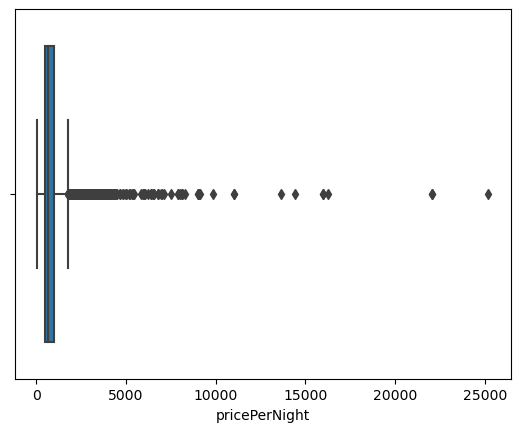

In [50]:
# Handling with outliers:

showOutliers(df, "pricePerNight")

It is clear to see here that the column "pricePerNight" has 360 outliers, according to the 1.5IQR method.

Now, we need to understand whether the exceptions are really true or not. If so, we should leave them as they are. If not, the outliers must be handled and replaced by the median, the most frequent value or the next cell - depends on the column type.

According to our data from Booking.com, there is a hotel that costs NIS 25,000 per night. There is no doubt that this is an outlier, as the average price is NIS 989 per night (25 times smaller!). However, we can see that this is a real price on Booking.com, so these cells should not be changed.

## Back to Step 2: Data Acquisition

### Data Acquisition by API

Now, we need to go back to step 2 - data acquisition.

At this point we will get the data about the distance of each city of a hotel to the TLV. This could not be done before step 3 of Data Handling, because at that stage we created a new column and extracted the city name from the entire address.

The "City" column will now help us get the distance from the hotel city to TLV.

#### Auxiliary Functions

In these two following function we calculate the distance between Tel-Aviv to another city.
The calculation using an API which called GEODB in order to get the city ID and to find the distance.

In [ ]:
def getCityID(cityName):

    # Set up the API endpoint URL
    url = "https://wft-geo-db.p.rapidapi.com/v1/geo/cities"

    # Set your API key and headers
    api_key = "b357d38c99mshac61197df8fd7c2p1d5cd7jsn2bfe93de690c"
    headers = {
        "X-RapidAPI-Key": api_key,
        "X-RapidAPI-Host": "wft-geo-db.p.rapidapi.com"
    }

    # Set the query parameters for the country code and name
    params = {
        "countryIds": "IL",
        "namePrefix": cityName
    }

    # Send GET request to the API
    response = requests.get(url, headers=headers, params=params)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the response JSON
        data = response.json()

        # Check if any cities were found
        if data["data"]:
            # Get the city ID from the first result
            city_id = data["data"][0]["id"]
            print("City ID:", city_id)
            return city_id
        else:
            print("No matching cities found.")
            return np.nan
    else:
        print("Error:", response.status_code)
        return np.nan

In [ ]:
def getCityDistance(cityID): 
    url = "https://wft-geo-db.p.rapidapi.com/v1/geo/cities/54067/distance"

    querystring = {"fromCityId":"54067","distanceUnit":"km","toCityId":cityID}

    headers = {
        "X-RapidAPI-Key": "b357d38c99mshac61197df8fd7c2p1d5cd7jsn2bfe93de690c",
        "X-RapidAPI-Host": "wft-geo-db.p.rapidapi.com"
    }

    response = requests.get(url, headers=headers, params=querystring)

    print(response.json())
    data = response.json()

    if "data" in data:
        return data["data"]
    else:
        return None

In [ ]:
# add a column with the distance from TLV
 # as real function
def addDisTlvCol(df):

    df['distance-TLV'] = ''

    city_name = df['City'].tolist()
    print(city_name)
    TLVDis= []
    
    for city in city_name:
        time.sleep(2)
        city_id = getCityID(city)
        time.sleep(1)
        city_distance = getCityDistance(city_id)
        TLVDis.append(city_distance)

    for j in range(len(TLVDis)):
        df.at[j,'distance-TLV'] = TLVDis[j]

    return df

#### Main Function

In [ ]:
###NOT important I have below the function which using the api to add new col with the distance to tlv
# cityName = "Haifa"
# city_id = getCityID(cityName)
# time.sleep(1)
# city_distance = getCityDistance(city_id)
# if city_distance is not None:
#     print("Distance:", city_distance)
# else:
#     print("Distance information not available.")


## Step 4: EDA

a little description and notes about this step...

#### Auxiliary Functions

In [ ]:
# Code:



#### Main Function

In [ ]:
# Main



write a bottom line about the corelation between distance and price...

## Step 5: Machine Learning

At this point we want to predict the price per night of a hotel, based on its city and its scores.

Since we want to predict an exact number, we need to use the Linear Regression method.

### Auxiliary Functions

In [53]:
# Create a scatterplot easily:

def showScatterPlot(df, xColumn, yCols, yCaption):

    markers = [".","s","P", "*", "D"]
    colors = ["r", "b", "k"]

    for index, yCol in enumerate(yCols):
        plt.scatter(x=df[xColumn],y=df[yCol],c=colors[index%3],marker=markers[index%5],label=yCol)

    plt.legend(numpoints=1,loc=4)
    plt.xlabel(xColumn)
    plt.ylabel(yCaption)
    plt.show()

In [52]:
# Create a scatterplot with predict of model:

def showScatterPlotPredict(df):
    
    plt.scatter(x=advert['Digital'],y=advert['Sales'],c='k',marker='*',label='Digital')
    plt.plot(advert['Digital'],m.predict(advert.iloc[:,0:1]),'k',color='blue',linewidth=3)

    plt.xlabel('Digital budget (Thousands of dollars)')
    plt.ylabel('Sales (Thousand units of product)')
    plt.show()

In [ ]:
# 

### Main Function

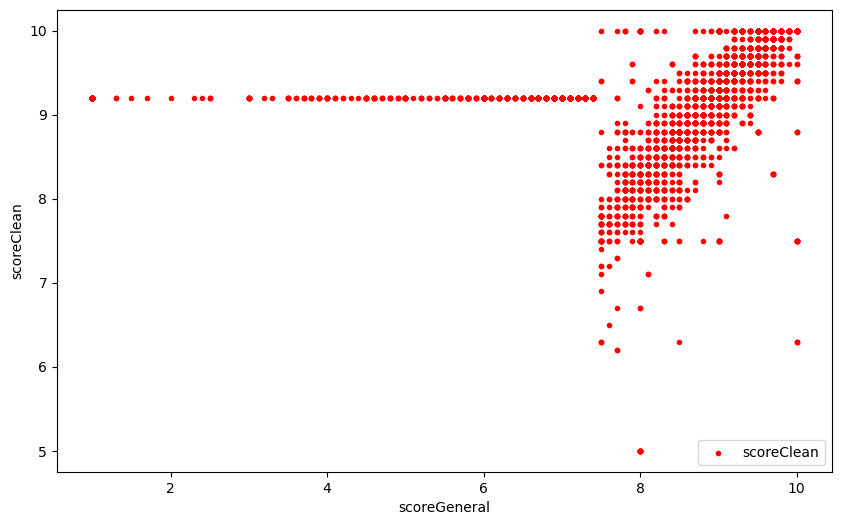

In [61]:
# Basic data visualisation for hints on regression:
showScatterPlot(df, "scoreGeneral", ["scoreClean"], "scoreClean")

According to the graph, it can be seen that there may be a linear regression relationship for these columns.

In [ ]:
m = linear_model.LinearRegression().fit(df.iloc[:,0:1],df.iloc[:,3:])
showScatterPlotPredict(df)

In [ ]:
# Evaluation of 

## Summary

a little paragraph that sums up the job

can't trust 100% third side - like the API, booking.com ...

repeat the conclusion about the corlation between the price and the distance, explain it is possible to predict ...

We enjoyed ... Recommend others to deal with Data Science...